# Classification: Bayesian Search - Oversampled Dataset

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn import tree
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import PredefinedSplit
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import make_scorer

## Parameter Selection

In [ ]:
# Merge results from previous random search
USER_1 = 'Jacopo'
USER_2 = 'Simone'

models = ['ada_boost', 'nn', 'xgb', 'naive_bayes', 'random_forest', 'decision_tree', 'svm', 'rule_based', 'knn']

for model in models:
    path_1 = f'../../data/ml_datasets/oversampling/model_selection/{USER_1}_{model}_results.csv'
    path_2 = f'../../data/ml_datasets/oversampling/model_selection/{USER_2}_{model}_results.csv'

    concatenate_path = f'../../data/ml_datasets/oversampling/model_selection/{model}_results.csv'

    df1 = pd.read_csv(path_1)
    df2 = pd.read_csv(path_2)

    df_concat = pd.concat([df1, df2], ignore_index=True) # Concat the two files
    df_concat.to_csv(concatenate_path, index=False)  # Save the result in a new CSV

In [3]:
columns_to_see = ['mean_test_f1_micro', 'mean_test_f1_1', 'mean_test_f1_0', 'mean_test_f1_macro']

In [11]:
# df = pd.read_csv('../../data/ml_datasets/oversampling/model_selection/ada_boost_results.csv')
# df.sort_values(by='mean_test_f1_micro', ascending=False, inplace=True)
# params= [col for col in df.columns if col.startswith("param_")]
# df.head(n=10)[columns_to_see+params]

In [4]:
models = ['ada_boost', 'nn', 'xgb', 'naive_bayes', 'random_forest', 'decision_tree', 'svm', 'rule_based', 'knn']

df_results = pd.read_csv('../../data/ml_datasets/oversampling/model_selection/nn_results.csv')
df_results = df_results.rename(columns={'mean_f1_micro': 'mean_test_f1_micro', 
                                        'std_f1_micro': 'std_test_f1_micro',
                                        'mean_f1_1': 'mean_test_f1_1',
                                        'std_f1_1': 'std_test_f1_1',
                                        'mean_f1_0': 'mean_test_f1_0',
                                        'std_f1_0': 'std_test_f1_0',
                                        'mean_f1_macro': 'mean_test_f1_macro', 
                                        'std_f1_macro': 'std_test_f1_macro',})
print(df_results.columns)
df_results = df_results[columns_to_see]
df_results['model'] = 'nn'
models.remove('nn')

columns_to_see = ['model'] + columns_to_see
for model in models:
    path = f'../../data/ml_datasets/oversampling/model_selection/{model}_results.csv'

    df = pd.read_csv(path)
    df['model'] = model
    df.sort_values(by='mean_test_f1_macro', ascending=False, inplace=True)
    df = df.head(10)
    df = df[columns_to_see]

    df_results = pd.concat([df_results, df], axis=0)

Index(['batch_size', 'epochs', 'units_layer1', 'units_layer2', 'drop_rate',
       'learning_rate', 'mean_test_f1_micro', 'std_test_f1_micro',
       'mean_test_f1_0', 'std_test_f1_0', 'mean_test_f1_1', 'std_test_f1_1',
       'mean_test_f1_macro'],
      dtype='object')


In [6]:
df_results.sort_values(by='mean_test_f1_macro', ascending=False, inplace=True)
df_results.head(40)

,mean_test_f1_micro,mean_test_f1_1,mean_test_f1_0,mean_test_f1_macro,model
15,0.854396,0.485541,0.915198,0.700369,random_forest
14,0.858062,0.479820,0.917819,0.698820,random_forest
13,0.858481,0.471561,0.918301,0.694931,random_forest
16,0.844311,0.479672,0.908461,0.694066,random_forest
18,0.838012,0.475128,0.904227,0.689678,random_forest
17,0.839732,0.471662,0.905539,0.688601,random_forest
21,0.806650,0.471103,0.881701,0.676402,random_forest
23,0.804689,0.470015,0.880286,0.675151,random_forest
22,0.804944,0.469089,0.880524,0.674806,random_forest
0,0.880446,0.413018,0.933446,0.673232,random_forest


Winner models for oversampling:
- Random Forests
- XGB
- Decision Tree
- Ada-Boost

In [8]:
df = pd.read_csv('../../data/ml_datasets/oversampling/model_selection/decision_tree_results.csv').drop(columns=['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time'])
df.sort_values(by='mean_test_f1_macro', ascending=False, inplace=True)
df.head(10)

,param_class_weight,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,...,std_test_f1_micro,rank_test_f1_micro,split0_test_f1_0,mean_test_f1_0,std_test_f1_0,rank_test_f1_0,split0_test_f1_1,mean_test_f1_1,std_test_f1_1,rank_test_f1_1
29,"{0: 0.8, 1: 0.2}",entropy,20.0,15,50,50,"{'class_weight': {0: 0.8, 1: 0.2}, 'criterion'...",0.638874,0.638874,0.0,...,0.0,30,0.914112,0.914112,0.0,31,0.363636,0.363636,0.0,101
11,"{0: 0.8, 1: 0.2}",entropy,15.0,15,100,20,"{'class_weight': {0: 0.8, 1: 0.2}, 'criterion'...",0.638447,0.638447,0.0,...,0.0,12,0.922011,0.922011,0.0,15,0.354883,0.354883,0.0,123
16,"{0: 0.8, 1: 0.2}",gini,20.0,14,100,50,"{'class_weight': {0: 0.8, 1: 0.2}, 'criterion'...",0.638111,0.638111,0.0,...,0.0,17,0.919415,0.919415,0.0,22,0.356807,0.356807,0.0,118
23,"{0: 0.8, 1: 0.2}",gini,20.0,14,100,30,"{'class_weight': {0: 0.8, 1: 0.2}, 'criterion'...",0.637320,0.637320,0.0,...,0.0,24,0.918805,0.918805,0.0,27,0.355835,0.355835,0.0,119
71,"{0: 0.6, 1: 0.4}",entropy,15.0,8,100,30,"{'class_weight': {0: 0.6, 1: 0.4}, 'criterion'...",0.637115,0.637115,0.0,...,0.0,72,0.866687,0.866687,0.0,73,0.407543,0.407543,0.0,1
31,"{0: 0.8, 1: 0.2}",gini,20.0,15,30,100,"{'class_weight': {0: 0.8, 1: 0.2}, 'criterion'...",0.635523,0.635523,0.0,...,0.0,32,0.913980,0.913980,0.0,32,0.357066,0.357066,0.0,116
37,"{0: 0.8, 1: 0.2}",gini,20.0,11,30,30,"{'class_weight': {0: 0.8, 1: 0.2}, 'criterion'...",0.634984,0.634984,0.0,...,0.0,38,0.911018,0.911018,0.0,38,0.358949,0.358949,0.0,111
59,"{0: 0.6, 1: 0.4}",entropy,10.0,6,20,100,"{'class_weight': {0: 0.6, 1: 0.4}, 'criterion'...",0.634763,0.634763,0.0,...,0.0,60,0.872862,0.872862,0.0,60,0.396664,0.396664,0.0,11
28,"{0: 0.8, 1: 0.2}",entropy,20.0,6,10,100,"{'class_weight': {0: 0.8, 1: 0.2}, 'criterion'...",0.634692,0.634692,0.0,...,0.0,29,0.915036,0.915036,0.0,29,0.354349,0.354349,0.0,125
77,"{0: 0.6, 1: 0.4}",gini,10.0,14,30,100,"{'class_weight': {0: 0.6, 1: 0.4}, 'criterion'...",0.634574,0.634574,0.0,...,0.0,78,0.863971,0.863971,0.0,81,0.405177,0.405177,0.0,2


Decision Tree:
- criterion: entropy, gini
- max_depth: 15-30
- max_features: 6 in su
- min_leaf: 30, 200 ogni 15
- min_samples_split: 20-150 ogni 10

In [9]:
df = pd.read_csv('../../data/ml_datasets/oversampling/model_selection/random_forest_results.csv').drop(columns=['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time'])
df.sort_values(by='mean_test_f1_macro', ascending=False, inplace=True)
df.head(10)

,param_class_weight,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_f1_macro,mean_test_f1_macro,...,std_test_f1_micro,rank_test_f1_micro,split0_test_f1_0,mean_test_f1_0,std_test_f1_0,rank_test_f1_0,split0_test_f1_1,mean_test_f1_1,std_test_f1_1,rank_test_f1_1
15,NaN,entropy,NaN,13,10,20,150,"{'class_weight': None, 'criterion': 'entropy',...",0.700369,0.700369,...,0.0,16,0.915198,0.915198,0.0,16,0.485541,0.485541,0.0,1
14,"{0: 0.6, 1: 0.4}",gini,20.0,11,10,20,100,"{'class_weight': {0: 0.6, 1: 0.4}, 'criterion'...",0.698820,0.698820,...,0.0,15,0.917819,0.917819,0.0,15,0.479820,0.479820,0.0,2
13,"{0: 0.6, 1: 0.4}",gini,NaN,15,10,20,50,"{'class_weight': {0: 0.6, 1: 0.4}, 'criterion'...",0.694931,0.694931,...,0.0,14,0.918301,0.918301,0.0,14,0.471561,0.471561,0.0,6
16,"{0: 0.6, 1: 0.4}",entropy,NaN,8,30,50,50,"{'class_weight': {0: 0.6, 1: 0.4}, 'criterion'...",0.694066,0.694066,...,0.0,17,0.908461,0.908461,0.0,17,0.479672,0.479672,0.0,3
18,"{0: 0.6, 1: 0.4}",gini,NaN,8,30,100,100,"{'class_weight': {0: 0.6, 1: 0.4}, 'criterion'...",0.689678,0.689678,...,0.0,19,0.904227,0.904227,0.0,19,0.475128,0.475128,0.0,4
17,"{0: 0.6, 1: 0.4}",gini,NaN,15,30,20,150,"{'class_weight': {0: 0.6, 1: 0.4}, 'criterion'...",0.688601,0.688601,...,0.0,18,0.905539,0.905539,0.0,18,0.471662,0.471662,0.0,5
21,NaN,entropy,NaN,5,30,20,150,"{'class_weight': None, 'criterion': 'entropy',...",0.676402,0.676402,...,0.0,22,0.881701,0.881701,0.0,22,0.471103,0.471103,0.0,7
23,balanced,entropy,20.0,11,10,100,150,"{'class_weight': 'balanced', 'criterion': 'ent...",0.675151,0.675151,...,0.0,24,0.880286,0.880286,0.0,24,0.470015,0.470015,0.0,8
22,balanced,entropy,20.0,14,30,50,150,"{'class_weight': 'balanced', 'criterion': 'ent...",0.674806,0.674806,...,0.0,23,0.880524,0.880524,0.0,23,0.469089,0.469089,0.0,9
0,"{0: 0.8, 1: 0.2}",entropy,NaN,11,10,50,150,"{'class_weight': {0: 0.8, 1: 0.2}, 'criterion'...",0.673232,0.673232,...,0.0,1,0.933446,0.933446,0.0,2,0.413018,0.413018,0.0,25


Random Forest:
- criterion: entropy, gini
- max_depth: NaN
- class_weight: 0.6-0.4, NaN
- max_features: 8 in su
- min_samples_leaf: 5-30
- min_samples_split: 10-150 ogni 10
- estimators: 50, 100, 150, 200

In [10]:
df = pd.read_csv('../../data/ml_datasets/oversampling/model_selection/xgb_results.csv').drop(columns=['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time'])
df.sort_values(by='mean_test_f1_macro', ascending=False, inplace=True)
df.head(10)

,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,split0_test_f1_micro,mean_test_f1_micro,std_test_f1_micro,rank_test_f1_micro,split0_test_f1_0,mean_test_f1_0,std_test_f1_0,rank_test_f1_0,split0_test_f1_1,mean_test_f1_1,std_test_f1_1,rank_test_f1_1
0,1.0,5,100,"{'learning_rate': 1, 'max_depth': 5, 'n_estima...",0.619855,0.619855,0.0,1.0,0.734139,0.734139,0.0,1,0.828289,0.828289,0.0,12,0.411422,0.411422,0.0,1
26,1.0,4,100,"{'learning_rate': 1, 'max_depth': 4, 'n_estima...",0.611501,0.611501,0.0,2.0,0.721241,0.721241,0.0,27,0.817981,0.817981,0.0,27,0.405020,0.405020,0.0,2
27,1.0,5,50,"{'learning_rate': 1, 'max_depth': 5, 'n_estima...",0.608182,0.608182,0.0,3.0,0.717067,0.717067,0.0,28,0.814732,0.814732,0.0,28,0.401633,0.401633,0.0,3
28,1.0,5,25,"{'learning_rate': 1, 'max_depth': 5, 'n_estima...",0.604252,0.604252,0.0,4.0,0.710932,0.710932,0.0,29,0.809723,0.809723,0.0,30,0.398780,0.398780,0.0,5
29,1.0,4,50,"{'learning_rate': 1, 'max_depth': 4, 'n_estima...",0.603449,0.603449,0.0,5.0,0.710229,0.710229,0.0,30,0.809225,0.809225,0.0,31,0.397674,0.397674,0.0,7
31,1.0,3,100,"{'learning_rate': 1, 'max_depth': 3, 'n_estima...",0.603278,0.603278,0.0,6.0,0.709286,0.709286,0.0,32,0.808353,0.808353,0.0,33,0.398204,0.398204,0.0,6
32,0.1,5,100,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.602254,0.602254,0.0,7.0,0.706174,0.706174,0.0,33,0.805561,0.805561,0.0,34,0.398947,0.398947,0.0,4
34,1.0,4,25,"{'learning_rate': 1, 'max_depth': 4, 'n_estima...",0.596415,0.596415,0.0,8.0,0.700727,0.700727,0.0,35,0.801595,0.801595,0.0,36,0.391234,0.391234,0.0,9
37,0.1,4,100,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.595379,0.595379,0.0,9.0,0.697256,0.697256,0.0,38,0.798410,0.798410,0.0,41,0.392348,0.392348,0.0,8
35,1.0,3,50,"{'learning_rate': 1, 'max_depth': 3, 'n_estima...",0.595261,0.595261,0.0,10.0,0.699964,0.699964,0.0,36,0.801119,0.801119,0.0,38,0.389403,0.389403,0.0,11


XGB:
- lr: 0.1-1
- max_depth: 3-15
- n_estimators: 50-175, ogni 25

In [11]:
df = pd.read_csv('../../data/ml_datasets/oversampling/model_selection/ada_boost_results.csv').drop(columns=['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time'])
df.sort_values(by='mean_test_f1_macro', ascending=False, inplace=True)
df.head(10)

,param_algorithm,param_learning_rate,param_n_estimators,params,split0_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,split0_test_f1_micro,mean_test_f1_micro,std_test_f1_micro,rank_test_f1_micro,split0_test_f1_0,mean_test_f1_0,std_test_f1_0,rank_test_f1_0,split0_test_f1_1,mean_test_f1_1,std_test_f1_1,rank_test_f1_1
10,SAMME,0.1000,100,"{'algorithm': 'SAMME', 'learning_rate': 0.1, '...",0.584997,0.584997,0.0,1.0,0.724578,0.724578,0.0,11,0.825676,0.825676,0.0,11,0.344317,0.344317,0.0,4
9,SAMME,0.1000,50,"{'algorithm': 'SAMME', 'learning_rate': 0.1, '...",0.584787,0.584787,0.0,2.0,0.724728,0.724728,0.0,10,0.825837,0.825837,0.0,10,0.343738,0.343738,0.0,5
2,SAMME,0.0001,50,"{'algorithm': 'SAMME', 'learning_rate': 0.0001...",0.583025,0.583025,0.0,3.0,0.725566,0.725566,0.0,1,0.826820,0.826820,0.0,1,0.339230,0.339230,0.0,6
1,SAMME,0.0100,50,"{'algorithm': 'SAMME', 'learning_rate': 0.01, ...",0.583025,0.583025,0.0,3.0,0.725566,0.725566,0.0,1,0.826820,0.826820,0.0,1,0.339230,0.339230,0.0,6
4,SAMME,0.0010,100,"{'algorithm': 'SAMME', 'learning_rate': 0.001,...",0.583025,0.583025,0.0,3.0,0.725566,0.725566,0.0,1,0.826820,0.826820,0.0,1,0.339230,0.339230,0.0,6
5,SAMME,0.0010,50,"{'algorithm': 'SAMME', 'learning_rate': 0.001,...",0.583025,0.583025,0.0,3.0,0.725566,0.725566,0.0,1,0.826820,0.826820,0.0,1,0.339230,0.339230,0.0,6
6,SAMME,0.0010,25,"{'algorithm': 'SAMME', 'learning_rate': 0.001,...",0.583025,0.583025,0.0,3.0,0.725566,0.725566,0.0,1,0.826820,0.826820,0.0,1,0.339230,0.339230,0.0,6
3,SAMME,0.0001,25,"{'algorithm': 'SAMME', 'learning_rate': 0.0001...",0.583025,0.583025,0.0,3.0,0.725566,0.725566,0.0,1,0.826820,0.826820,0.0,1,0.339230,0.339230,0.0,6
0,SAMME,0.0100,25,"{'algorithm': 'SAMME', 'learning_rate': 0.01, ...",0.583025,0.583025,0.0,3.0,0.725566,0.725566,0.0,1,0.826820,0.826820,0.0,1,0.339230,0.339230,0.0,6
8,SAMME,0.0001,100,"{'algorithm': 'SAMME', 'learning_rate': 0.0001...",0.583025,0.583025,0.0,3.0,0.725566,0.725566,0.0,1,0.826820,0.826820,0.0,1,0.339230,0.339230,0.0,6


Ada-Boost:
- lr: 0.1-0.00001 ogni 0.0005
- n_estimators: 25-175, ogni 25

## Bayesian Search

In [8]:
RANDOM_STATE = 42

train_data = pd.read_csv('../../data/ml_datasets/oversampling/train_set.csv').sample(frac = 1, random_state=RANDOM_STATE) # Shuffling the data to not introduce bias
val_data = pd.read_csv('../../data/ml_datasets/oversampling/val_set.csv')
testing_data = pd.read_csv('../../data/ml_datasets/oversampling/test_set.csv')

In [9]:
train_label = train_data.pop('label')
val_label = val_data.pop('label')
test_label = testing_data.pop('label')

train_set = train_data
train_set['race_season%autumn'] = train_set['race_season%autumn'].astype(int)
train_set['race_season%spring'] = train_set['race_season%spring'].astype(int)
train_set['race_season%summer'] = train_set['race_season%summer'].astype(int)
train_set['race_season%winter'] = train_set['race_season%winter'].astype(int)

val_set = val_data
val_set['race_season%autumn'] = val_set['race_season%autumn'].astype(int)
val_set['race_season%spring'] = val_set['race_season%spring'].astype(int)
val_set['race_season%summer'] = val_set['race_season%summer'].astype(int)
val_set['race_season%winter'] = val_set['race_season%winter'].astype(int)

test_set = testing_data
test_set['race_season%autumn'] = test_set['race_season%autumn'].astype(int)
test_set['race_season%spring'] = test_set['race_season%spring'].astype(int)
test_set['race_season%summer'] = test_set['race_season%summer'].astype(int)
test_set['race_season%winter'] = test_set['race_season%winter'].astype(int)

N_JOBS = 4
USER = 'Jacopo'

In [4]:
# Function to search for the best hyperparameters
def f1_class_scorer(class_index):
    # Function to calculate F1 score for a specific class
    def score_function(y_true, y_pred):
        return f1_score(y_true, y_pred, average=None)[class_index] # Compute the F1 score for each class and return the one specified
    return make_scorer(score_function)

# Scorer for class 0 and 1
f1_class_0 = f1_class_scorer(0)
f1_class_1 = f1_class_scorer(1)

scoring={
        'f1_macro': 'f1_macro', # F1 macro for each class
        'f1_0': f1_class_0,     # F1 only for class 0
        'f1_1': f1_class_1      # F1 only for class 1
}

In [5]:
i = 1
def func(*args):
    global i
    print(f'Configurazione: {i}')
    i += 1

In [ ]:
N_FEATURES = len(train_set.iloc[0])

train_set = train_set.to_numpy()
train_label = train_label.to_numpy()

val_set = val_set.to_numpy()
val_label = val_label.to_numpy()

split_index = np.concatenate([
    np.full(len(train_set), -1), # -1 for training
    np.zeros(len(val_set))       # 0 for validation
])

X_combined = np.vstack((train_set, val_set))
y_combined = np.concatenate((train_label, val_label))

ps = PredefinedSplit(test_fold=split_index)

### Decision Tree

Decision Tree:
- criterion: entropy, gini
- max_depth: 15-30
- max_features: 6 in su
- min_leaf: 30-210 ogni 15
- min_samples_split: 20-150 ogni 10

In [ ]:
param_dist = {"max_depth": Integer(15, 30),
              "max_features": Integer(6, N_FEATURES),
              "min_samples_split": Categorical(list(range(20, 151, 10))),
              "min_samples_leaf": Categorical(list(range(30, 211, 15))),
              "criterion": Categorical(['gini', 'entropy'])}
n_iter_search = 100 # Number of iterations
clf = tree.DecisionTreeClassifier() # Model

# Define the grid search
rand_search = BayesSearchCV(clf, search_spaces=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=N_JOBS, 
                            scoring=scoring,
                            refit='f1_macro',
                            cv=ps)
i = 1
rand_search.fit(X_combined, y_combined, callback=func);

In [ ]:
df = pd.DataFrame(rand_search.cv_results_)
df.sort_values(by='rank_test_f1_macro', inplace=True)
df.to_csv(f'../../data/ml_datasets/oversampling/model_selection/{USER}_decision_tree_results_bayes.csv', index=False)
df.head(n=10)[['mean_test_f1_macro', 'std_test_f1_macro', 'mean_test_f1_1', 'std_test_f1_1', 'mean_test_f1_0', 'std_test_f1_0']]

### Random Forest

Random Forest:
- criterion: entropy, gini
- max_depth: NaN
- class_weight: 0.6-0.4, NaN
- max_features: 8 in su
- min_samples_leaf: 5-30
- min_samples_split: 10-150 ogni 10
- estimators: 50, 100, 150, 200

In [ ]:
param_dist = {"max_features": Integer(8, N_FEATURES),
              "min_samples_split": Categorical(list(range(10, 151, 10))),
              "min_samples_leaf": Integer(5, 30),
              "criterion": Categorical(['gini', 'entropy']),
              "n_estimators": Categorical([50, 100, 150, 200]),
              "class_weight": Categorical([{0:0.6, 1:0.4}, None])}
n_iter_search = 100 # Number of iterations
clf = RandomForestClassifier() # Model

# Define the grid search
rand_search = BayesSearchCV(clf, search_spaces=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=N_JOBS, 
                            scoring=scoring,
                            refit='f1_macro',
                            cv=ps)
i = 1
rand_search.fit(X_combined, y_combined, callback=func);

In [ ]:
df = pd.DataFrame(rand_search.cv_results_)
df.sort_values(by='rank_test_f1_macro', inplace=True)
df.to_csv(f'../../data/ml_datasets/oversampling/model_selection/{USER}_random_forest_results_bayes.csv', index=False)
df.head(n=10)[['mean_test_f1_macro', 'std_test_f1_macro', 'mean_test_f1_1', 'std_test_f1_1', 'mean_test_f1_0', 'std_test_f1_0']]

### XGBoost

XGB:
- lr: 0.1-1
- max_depth: 3-15
- n_estimators: 50-175, ogni 25

In [ ]:
param_dist = {
    "n_estimators": Categorical(list(range(50, 176, 25))),
    "max_depth": Integer(3, 15), 
    "learning_rate": Real(0.1, 1)
}
n_iter_search = 100 # Number of iterations
clf = XGBClassifier() # Model

# Define the grid search
rand_search = BayesSearchCV(clf, search_spaces=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=N_JOBS, 
                            scoring=scoring,
                            refit='f1_macro',
                            cv=ps)
i = 1
rand_search.fit(X_combined, y_combined, callback=func);

In [ ]:
df = pd.DataFrame(rand_search.cv_results_)
df.sort_values(by='rank_test_f1_macro', inplace=True)
df.to_csv(f'../../data/ml_datasets/oversampling/model_selection/{USER}_xgb_results_bayes.csv', index=False)
df.head(n=10)[['mean_test_f1_macro', 'std_test_f1_macro', 'mean_test_f1_1', 'std_test_f1_1', 'mean_test_f1_0', 'std_test_f1_0']]

### AdaBoost

Ada-Boost:
- lr: 0.1-0.00001 ogni 0.0005
- n_estimators: 25-175, ogni 25

In [ ]:
param_dist = {
    "n_estimators": Categorical(list(range(25, 176, 25))),  
    "learning_rate": Categorical(np.arange(0.1, 0.00001, -0.0005).tolist()),  
    "algorithm": Categorical(['SAMME']) 
}
n_iter_search = 100 # Number of iterations
clf = AdaBoostClassifier() # Model

# Define the grid search
rand_search = BayesSearchCV(clf, search_spaces=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=N_JOBS, 
                            scoring=scoring,
                            refit='f1_macro',
                            cv=ps)
i = 1
rand_search.fit(X_combined, y_combined, callback=func);

In [ ]:
df = pd.DataFrame(rand_search.cv_results_)
df.sort_values(by='rank_test_f1_macro', inplace=True)
df.to_csv(f'../../data/ml_datasets/oversampling/model_selection/{USER}_ada_boost_results_bayes.csv', index=False)
df.head(n=10)[['mean_test_f1_macro', 'std_test_f1_macro', 'mean_test_f1_1', 'std_test_f1_1', 'mean_test_f1_0', 'std_test_f1_0']]

## Winners

In [10]:
columns_to_see = ['mean_test_f1_1', 'mean_test_f1_0', 'mean_test_f1_macro', 'model']
USER_1 = 'Jacopo'
USER_2 = 'Simone'

models = ['ada_boost', 'xgb', 'random_forest']
path_dt = f'../../data/ml_datasets/oversampling/model_selection/{USER_1}_decision_tree_results_bayes.csv'
path_ada = f'../../data/ml_datasets/oversampling/model_selection/{USER_1}_ada_boost_results_bayes.csv'
path_xgb = f'../../data/ml_datasets/oversampling/model_selection/{USER_2}_xgb_results_bayes.csv'
path_rf = f'../../data/ml_datasets/oversampling/model_selection/{USER_2}_random_forest_results_bayes.csv'

path_list = [path_ada, path_xgb, path_rf]

df_results = pd.read_csv(path_dt)
df_results['model'] = 'decision_tree'
df_results = df_results[columns_to_see]

for i, path in enumerate(path_list):
    df = pd.read_csv(path)
    df['model'] = models[i]
    df.sort_values(by='mean_test_f1_macro', ascending=False, inplace=True)
    df = df[columns_to_see]

    df_results = pd.concat([df_results, df], axis=0)

In [11]:
df_results.sort_values(by='mean_test_f1_macro', ascending=False, inplace=True)
df_results.head(10)

,mean_test_f1_1,mean_test_f1_0,mean_test_f1_macro,model
0,0.486121,0.921442,0.703781,random_forest
1,0.481108,0.926045,0.703577,random_forest
0,0.485595,0.921474,0.703535,xgb
1,0.488323,0.918479,0.703401,xgb
2,0.487602,0.918668,0.703135,random_forest
3,0.478780,0.927105,0.702943,random_forest
4,0.484297,0.921266,0.702782,random_forest
5,0.481473,0.923881,0.702677,random_forest
2,0.483113,0.921988,0.702550,xgb
3,0.485114,0.919681,0.702398,xgb


The winner model is the "Random Forest", next step is to take the "best" hyperparameters and retrain the model on the whole developmente set

In [7]:
USER_2 = 'Simone'
path_rf = f'../../data/ml_datasets/oversampling/model_selection/{USER_2}_random_forest_results_bayes.csv'
df_rf = pd.read_csv(path_rf).drop(columns=['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time'])
df_rf.sort_values(by='rank_test_f1_macro', inplace=True)
df_rf.head(5)

,param_class_weight,param_criterion,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,split0_test_f1_0,mean_test_f1_0,std_test_f1_0,rank_test_f1_0,split0_test_f1_1,mean_test_f1_1,std_test_f1_1,rank_test_f1_1
0,NaN,entropy,8,5,20,150,"OrderedDict([('class_weight', None), ('criteri...",0.703781,0.703781,0.0,1,0.921442,0.921442,0.0,21,0.486121,0.486121,0.0,6
1,"{0: 0.6, 1: 0.4}",gini,8,5,20,200,"OrderedDict([('class_weight', {0: 0.6, 1: 0.4}...",0.703577,0.703577,0.0,2,0.926045,0.926045,0.0,8,0.481108,0.481108,0.0,27
2,NaN,gini,8,5,20,150,"OrderedDict([('class_weight', None), ('criteri...",0.703135,0.703135,0.0,3,0.918668,0.918668,0.0,31,0.487602,0.487602,0.0,3
3,"{0: 0.6, 1: 0.4}",entropy,8,5,20,200,"OrderedDict([('class_weight', {0: 0.6, 1: 0.4}...",0.702943,0.702943,0.0,4,0.927105,0.927105,0.0,6,0.478780,0.478780,0.0,45
4,NaN,entropy,8,5,20,200,"OrderedDict([('class_weight', None), ('criteri...",0.702782,0.702782,0.0,5,0.921266,0.921266,0.0,25,0.484297,0.484297,0.0,11


## Test Assessment

In [24]:
dev_set = pd.concat([train_data, val_data])
dev_label = pd.concat([train_label, val_label])
dev_label.value_counts(normalize=True)

label
0    0.546106
1    0.453894
Name: proportion, dtype: float64

In [25]:
rf_clf = RandomForestClassifier(class_weight=None, criterion='entropy', max_features=8, min_samples_leaf=5, min_samples_split=20, n_estimators=150)

rf_clf.fit(dev_set, dev_label)

predicitions = rf_clf.predict(test_set)
print(classification_report(test_label, predicitions))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91     27446
           1       0.42      0.36      0.38      4203

    accuracy                           0.85     31649
   macro avg       0.66      0.64      0.65     31649
weighted avg       0.84      0.85      0.84     31649



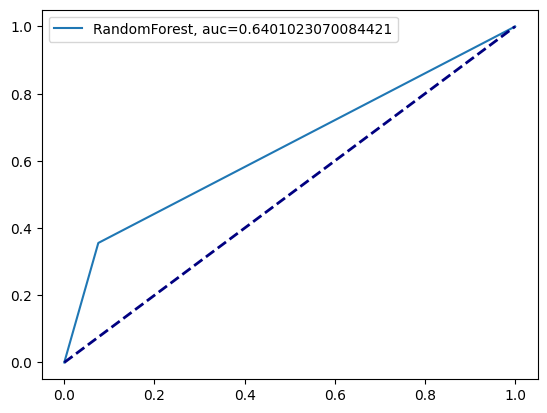

In [27]:
plt.figure(0).clf()
fpr, tpr, thresh = metrics.roc_curve(test_label, predicitions)
auc = metrics.roc_auc_score(test_label, predicitions)
plt.plot(fpr,tpr,label="RandomForest, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=0)